In [ ]:
import os
import numpy as np
import pandas as pd

import pymatgen as pg

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [3]:

def local_min(df):

    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()

    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] > 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df
    local_mins = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)

    return local_mins

def local_max(df):
    df['dy'] = df['Edis'].diff()

    df['sign_dy'] = np.sign(df['dy'])
    df['sign_change'] = df['sign_dy'].diff()
    
    # Indices of local maxima: derivative goes from negative (-1) to positive (+1)
    local_min_indices = df.index[(df['sign_change'] < 0)]

    if len(local_min_indices) == 0:
        print('No local max found')
        new_df = pd.DataFrame(columns=['cell_length', 'Edis'])
        # put values 0 , 0 in the dataframe
        new_df.loc[0] = [0, 0]
        print(min(new_df['Edis']))
        return new_df

    local_max = df.loc[local_min_indices, ['cell_length', 'Edis']].reset_index(drop=True)
    return local_max

In [4]:
def finding_diff(df):
    abs_max = df['Edis'].iloc[-1]
    max_val = max(local_max(df)['Edis'])
    min_val = min(local_min(df)['Edis'])
    min_val_idx = local_min(df)[local_min(df)['Edis'] == min_val].index[0]
    min_length = local_min(df).loc[min_val_idx, 'cell_length']
    
    max_val_idx = local_max(df)[local_max(df)['Edis'] == max_val].index[0]
    
    # equation of line between two points (x1, y1) and (x2, y2)
    x1 = local_max(df).loc[max_val_idx, 'cell_length'] 
    x2 = df['cell_length'].iloc[-1]

    y1 = max_val
    y2 = abs_max
    # print(min_length)
    
    # Finding the maximum slope
    max_slope = float('-inf')
    best_x2 = x2
    best_y2 = y2
    
    # Get the dataframe points after x1
    points_after_x1 = df[df['cell_length'] > x1][['cell_length', 'Edis']]
    
    # Iterate through all points after x1
    for idx, row in points_after_x1.iterrows():
        temp_x2 = row['cell_length']
        temp_y2 = row['Edis']
        temp_slope = (y1 - temp_y2) / (x1 - temp_x2)
        
        if temp_slope > max_slope:
            max_slope = temp_slope
            best_x2 = temp_x2
            best_y2 = temp_y2
    
    x2 = best_x2
    y2 = best_y2
    slope = max_slope
    intercept = y2 - slope * x2

    if y2 < y1:
        slope = 0
        intercept = y1

    #value of y when x = min_length
    y_at_min_length = slope * min_length + intercept

    diff = abs(min_val - y_at_min_length)
    return diff


In [5]:
from pymatgen.core import Structure

In [ ]:
#list all folders inside li_d3s
li_d3s = os.listdir("d3_calcs")

results = []

df = pd.DataFrame()
cnt=0
for items in li_d3s:
    cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')
    df = pd.read_csv(file)
    print(f"Reading {file}")
    # exract materials id from file name

    material_id = os.path.basename(file).split('.')[0].split('_')[1]
    print(f"Material ID: mp-{material_id}")
    struct = Structure.from_file(struct_file)
    sites = struct.num_sites
    
    # print(struct.composition['Li'])
    li_sites = struct.composition['Zn']
    counter_ion_sites = struct.composition[struct.composition.elements[1]]
    diff_energy = finding_diff(df)
    print(f'Composition {struct.composition}')
    print(f'diff per toal sites {diff_energy/sites}')
    print(f'diff per cation sites {diff_energy/li_sites}')
    print('-----------------------------------')

    result = {
        "Symbol": struct.composition.elements[0] if struct.composition.elements[0].symbol != 'Zn' else struct.composition.elements[1],
        "Structure": struct.composition,
        "Total Sites": sites,
        "Cation Sites": li_sites,
        "Counter Ion Sites": counter_ion_sites,
        "Diff Energy": diff_energy,
        "Diff per Total Sites": diff_energy/sites,
        "Diff per Cation Sites": diff_energy/li_sites,
        "Diff per Counter Ion Sites": diff_energy/counter_ion_sites,
        "Volume": struct.volume,
        "mid": material_id,
        "Composition": str(struct.composition)
    }

    results.append(result)
print(f'total structure analysed = {cnt}')

Reading d3_calcs/ZnS_554999/ZnS_554999.csv
Material ID: mp-554999
Composition Zn24 S24
diff per toal sites 0.0009405674289120839
diff per cation sites 0.0018811348578241678
-----------------------------------
Reading d3_calcs/LuZn_11496/LuZn_11496.csv
Material ID: mp-11496
Composition Lu1 Zn1
diff per toal sites 0.01350027526648424
diff per cation sites 0.02700055053296848
-----------------------------------
Reading d3_calcs/ZnRh_6938/ZnRh_6938.csv
Material ID: mp-6938
Composition Zn1 Rh1
diff per toal sites 0.02172351413910795
diff per cation sites 0.0434470282782159
-----------------------------------
Reading d3_calcs/ErZn2_1025096/ErZn2_1025096.csv
Material ID: mp-1025096
Composition Er2 Zn4
diff per toal sites 0.012044358011442003
diff per cation sites 0.018066537017163004
-----------------------------------
Reading d3_calcs/Er2Zn17_30963/Er2Zn17_30963.csv
Material ID: mp-30963
Composition Er2 Zn17
diff per toal sites 0.011119182782628407
diff per cation sites 0.012427321933525868


### for individual elements

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv("analysis_results.csv", index=False)

print(f"Total structures analysed = {cnt}")
# print("Results saved to analysis_results.csv")

results_df['Diff per Total Sites'].max()*1000

Total structures analysed = 342


21.72351413910795

### Thougest part is to make the Feature functions data 


In [8]:
props = pd.read_csv('../mixed_comps/PubChemElements_all.csv')
polarisability = pd.read_csv('../elements_polarizability.csv')

props = props[['Symbol', 'AtomicMass','AtomicRadius','Electronegativity','IonizationEnergy','ElectronAffinity']]

In [9]:
all_props = []
cnt = 0
for items in li_d3s:
    # cnt+=1
    #get the path of each folder
    path = os.path.join("d3_calcs", items)
    # print(items)
    
    #ignore .DS_Store
    if items == ".DS_Store":
        continue
    file = os.path.join(path, f'{items}.csv')
    struct_file = os.path.join(path, 'POSCAR')


    struct = Structure.from_file(struct_file)
    sites = struct.num_sites

    vol_site = struct.volume/sites
    # print(density)

    # print(struct.composition.elements[1])

    elem = struct.composition.elements[0] if(struct.composition.elements[1].symbol == 'Zn')  else struct.composition.elements[1]

    print(elem)
    # print(elem.symbol == 'Ge')

    matched_row = props[props['Symbol'] == elem.symbol]
    elem_polarizability = polarisability[polarisability['Symbol'] == elem.symbol]

    space_group = struct.get_space_group_info()


    
    print(struct.composition.reduced_formula)
    # DiffPerLi = results_df[results_df['Symbol'] == elem.symbol]
    # matched_row.add('Polarizability', elem_polarizability['Polarizability'].values[0])
    matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
    matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
    matched_row['results_per_cation'] = results_df['Diff per Cation Sites'][cnt]*1000
    # matched_row['TotalSites'] = results_df['Total Sites'][cnt]
    matched_row['CationSites'] = results_df['Cation Sites'][cnt]/sites
    matched_row['CounterIonSites'] = results_df['Counter Ion Sites'][cnt]/sites
    matched_row['results_per_counter_ion'] = results_df['Diff per Counter Ion Sites'][cnt]
    # matched_row['Diff per Li Sites'] = DiffPerLi['Diff per Li Sites'].values[0]
    matched_row['res_per_volm_per_site'] = results_df['Diff per Total Sites'][cnt]/vol_site
    matched_row['Result']=  results_df['Diff per Total Sites'][cnt]/vol_site*1000
    matched_row['SpaceGroup'] = space_group[0]
    matched_row['SpaceGroupNumber'] = space_group[1]
    matched_row['Total Sites'] = sites
    matched_row['Volume'] = results_df['Volume'][cnt]
    matched_row['mid'] = results_df['mid'][cnt]
    matched_row["Reduced Formula"] = struct.composition.reduced_formula
    all_props.append(matched_row)

    cnt+=1

all_props_df = pd.concat(all_props, ignore_index=True)
    

S
ZnS
Lu
LuZn
Rh
ZnRh
Er
ErZn2
Er
Er2Zn17
Ru
Zn6Ru
Ho
Ho2Zn17
S
ZnS
S
ZnS
O
ZnO
S
ZnS
S
ZnS
S
ZnS
S
ZnS
Lu
Lu2Zn17
La
La2Zn17
S
ZnS
N
ZnN
Tm
TmZn12
Er
ErZn
N
Zn3N2
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
Au
ZnAu
Ce
Ce3Zn22
Eu
EuZn2
S
ZnS
Y
Y3Zn11
S
ZnS
Th
ThZn2
S
ZnS
Cl
ZnCl2
S
ZnS
Pr
PrZn
S
ZnS
S
ZnS
N
ZnN6
Ba
BaZn2
Pt
ZnPt
S
ZnS
S
ZnS
I
ZnI2
N
ZnN6
N
ZnN6
S
ZnS
S
ZnS
S
ZnS
O
ZnO
S
ZnS
S
ZnS
Nd
Nd2Zn17
Ti
Ti2Zn
Ba
BaZn5
S
ZnS
N
ZnN6
S
ZnS
Se
ZnSe
S
ZnS
S
ZnS
S
ZnS
Ta
Ta6Zn7
S
ZnS
Rh
Zn13Rh
Sc
ScZn


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:41: SettingWith

S
ZnS
S
ZnS
Ba
BaZn13
Er
ErZn12
S
ZnS
Ho
HoZn12
Ce
CeZn11
Tm
TmZn2
S
ZnS
N
Zn3N2
Ce
Ce2Zn17
Co
Zn11Co2
S
ZnS
N
ZnN
Sc
ScZn12
S
ZnS
S
ZnS
C
ZnC2
Tb
TbZn2
Au
Zn3Au
Mg
Mg2Zn11
S
ZnS
S
ZnS
La
LaZn4
O
ZnO
U
U2Zn17
Sc
ScZn2
Ho
HoZn
S
ZnS
S
ZnS
Cu
Zn8Cu5
Nb
NbZn2
S
ZnS
S
ZnS
S
ZnS
Ca
Ca5Zn3
Pt
Zn49Pt29
Pd
ZnPd
Y
YZn
S
ZnS
S
ZnS
Ho
HoZn3
Y
Y2Zn17
Tm
Tm2Zn17
S
ZnS
S
ZnS
Au
ZnAu3
S
ZnS
S
ZnS
S
ZnS
S
ZnS
Tm
TmZn
O
ZnO2
S
ZnS
S
ZnS
Nb
NbZn16
Pr
Pr3Zn22
O
ZnO
S
ZnS
Dy
DyZn12
S
ZnS
S
ZnS
O
ZnO
S
ZnS
Nd
NdZn
S
ZnS
Y
YZn3
Ni
ZnNi
S
ZnS
K
KZn13
F
ZnF2
Ho
HoZn2
Tb
TbZn3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:41: SettingWith

S
ZnS
S
ZnS
Nb
Nb6Zn7
S
ZnS
S
ZnS2
Pd
ZnPd2
Fe
Zn13Fe
Br
ZnBr2
S
ZnS
S
ZnS
S
ZnS
V
V4Zn5
Lu
LuZn3
Co
Zn13Co
Y
YZn5
C
Zn3C
Eu
EuZn11
Lu
LuZn12
Ce
Ce3Zn11
Mg
Mg4Zn7
S
ZnS
Ca
CaZn2
S
ZnS
P
ZnP2
Pt
ZnPt3
As
ZnAs2
O
ZnO
S
ZnS
O
ZnO2
Li
LiZn
Sr
SrZn
Sr
SrZn13
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
N
ZnN
O
ZnO
Pr
PrZn11
Dy
Dy2Zn17
S
ZnS
N
Zn3N
Y
YZn12
O
ZnO2
Th
Th2Zn
Ba
Ba2Zn
S
ZnS
Sm
SmZn12
S
ZnS
O
ZnO
Pu
Pu3Zn22
Ru
Zn3Ru
Lu
LuZn2
S
ZnS
Sm
SmZn2
Tb
TbZn12
Gd
GdZn2
N
Zn3N
Pu
Pu2Zn17
S
ZnS
S
ZnS
Se
ZnSe2
S
ZnS
Nd
NdZn2
S
ZnS
S
ZnS
S
ZnS
Mg
MgZn2
Eu
EuZn5
Pr
Pr2Zn17
Sm
Sm3Zn22
S
ZnS
S
ZnS
S
ZnS
N
ZnN
S
ZnS
O
ZnO


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:41: SettingWith

S
ZnS
Nd
NdZn11
Rb
RbZn13
N
Zn3N2
S
ZnS
S
ZnS
Nd
Nd3Zn22
S
ZnS
S
ZnS
S
ZnS
Pr
Pr13Zn58
Dy
DyZn2
S
ZnS
O
ZnO
Na
NaZn13
O
ZnO2
S
ZnS
S
ZnS
Nd
Nd3Zn11
N
ZnN6
Sb
ZnSb
Ce
CeZn3
Tb
Tb3Zn11
S
ZnS
Th
ThZn4
Mo
Zn6Mo
S
ZnS
S
ZnS
Ni
Zn11Ni2
Ca
CaZn
Tm
TmZn3
Pr
PrZn2
La
La3Zn22
Zr
ZrZn2
S
ZnS
O
ZnO
Gd
GdZn
S
ZnS
Ca
CaZn11
As
Zn3As2
Ce
CeZn2
Er
ErZn3
S
ZnS
Sm
SmZn
Eu
EuZn
La
LaZn13
C
Zn3C
Sr
SrZn2
S

/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:41: SettingWith


ZnS
Sm
SmZn3
S
ZnS
Mg
Mg21Zn25
S
ZnS
Dy
DyZn3
Yb
YbZn2
Rh
Zn11Rh2
S
ZnS
S
ZnS
O
ZnO2
La
LaZn
Th
Th2Zn17
S
ZnS
Hf
HfZn2
S
ZnS
O
ZnO2
Ir
Zn11Ir2
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
Hf
Hf2Zn
S
ZnS
Ho
Ho13Zn58
Sm
Sm2Zn17
S
ZnS
Dy
DyZn
Gd
Gd2Zn17
S
ZnS
S
ZnS
S
ZnS
La
LaZn11
Ta
TaZn2
S
ZnS
S
ZnS
S
ZnS
Nd
NdZn3
O
ZnO
S
ZnS
Zr
ZrZn
Te
ZnTe
Sr
SrZn5
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
S
ZnS
P
Zn3P2
S
ZnS
S
ZnS
Ca
CaZn5
Tb
Tb2Zn17
La
LaZn2
S
ZnS
S
ZnS
Mn
MnZn3
Tb
TbZn
S
ZnS
Dy
DyZn5
S
ZnS
S
ZnS
S
ZnS
Cu
ZnCu
Dy
Dy3Zn11
V
VZn3
S
ZnS
Sm
Sm3Zn11
Ti
TiZn16
S
ZnS
S
ZnS
S
ZnS
Nb
NbZn3


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['Polarizability'] = elem_polarizability['Polarizability'].values[0]
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_row['results_per_total'] = results_df['Diff per Total Sites'][cnt]*1000
/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_15069/4042131156.py:41: SettingWith

In [10]:
all_props_df


,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_cation,CationSites,CounterIonSites,results_per_counter_ion,res_per_volm_per_site,Result,SpaceGroup,SpaceGroupNumber,Total Sites,Volume,mid,Reduced Formula
0,S,32.07000,180.0,2.58,10.360,2.077,19.4,0.940567,1.881135,0.500000,0.500000,0.001881,0.000048,0.048112,P3m1,156,48,938.384916,554999,ZnS
1,Lu,174.96670,221.0,1.27,5.426,NaN,137.0,13.500275,27.000551,0.500000,0.500000,0.027001,0.000654,0.654231,Pm-3m,221,2,41.270660,11496,LuZn
2,Rh,102.90550,195.0,2.28,7.459,1.137,66.0,21.723514,43.447028,0.500000,0.500000,0.043447,0.001625,1.624979,Pm-3m,221,2,26.736970,6938,ZnRh
3,Er,167.26000,235.0,1.24,6.108,NaN,150.0,12.044358,18.066537,0.666667,0.666667,0.018067,0.000631,0.631365,Imma,74,6,114.460246,1025096,ErZn2
4,Er,167.26000,235.0,1.24,6.108,NaN,150.0,11.119183,12.427322,0.894737,0.894737,0.012427,0.000726,0.726033,R-3m,166,19,290.984653,30963,Er2Zn17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,Ti,47.86700,187.0,1.54,6.828,0.079,100.0,8.905290,9.461871,0.941176,0.941176,0.009462,0.000614,0.614016,Cmcm,63,34,493.113895,2327,TiZn16
338,S,32.07000,180.0,2.58,10.360,2.077,19.4,0.942078,1.884156,0.500000,0.500000,0.001884,0.000048,0.048192,P3m1,156,36,703.738606,556448,ZnS
339,S,32.07000,180.0,2.58,10.360,2.077,19.4,0.215601,0.431202,0.500000,0.500000,0.000431,0.000009,0.009203,P1,1,100,2342.783221,1245280,ZnS
340,S,32.07000,180.0,2.58,10.360,2.077,19.4,0.907192,1.814384,0.500000,0.500000,0.001814,0.000046,0.046343,P3m1,156,48,939.631180,554115,ZnS


In [11]:
all_props_df.to_csv('all_props_new.csv', index=False)

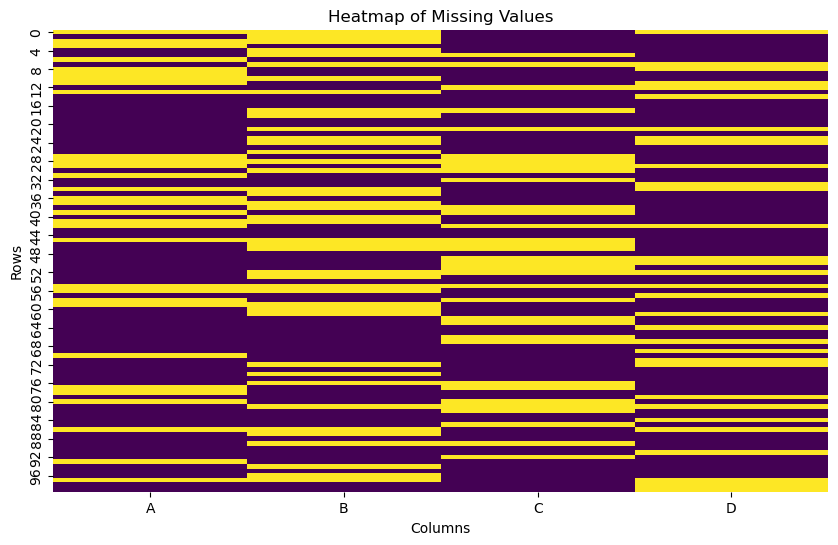

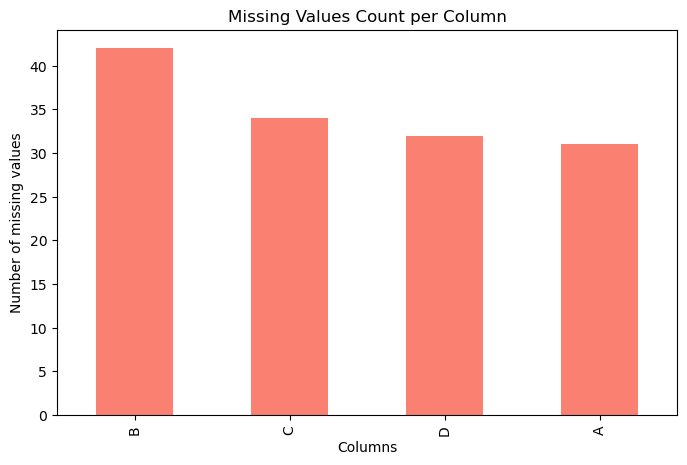

In [12]:
# show me some graphs to analyze NaN values

import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with NaN values (replace this with your actual DataFrame)
# For demonstration, we're creating a DataFrame with some random missing values.
np.random.seed(42)
data = {
    'A': np.random.choice([1, 2, np.nan], size=100),
    'B': np.random.choice([3, 4, np.nan], size=100),
    'C': np.random.choice([5, 6, np.nan], size=100),
    'D': np.random.choice([7, 8, np.nan], size=100)
}
df = pd.DataFrame(data)

# -------------------------------
# Plot 1: Heatmap of Missing Values
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# -------------------------------
# Plot 2: Bar Chart of Missing Values per Column
# -------------------------------
missing_counts = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
missing_counts.plot(kind="bar", color='salmon')
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.title("Missing Values Count per Column")
plt.show()

In [13]:
all_props_df.fillna(0, inplace=True)


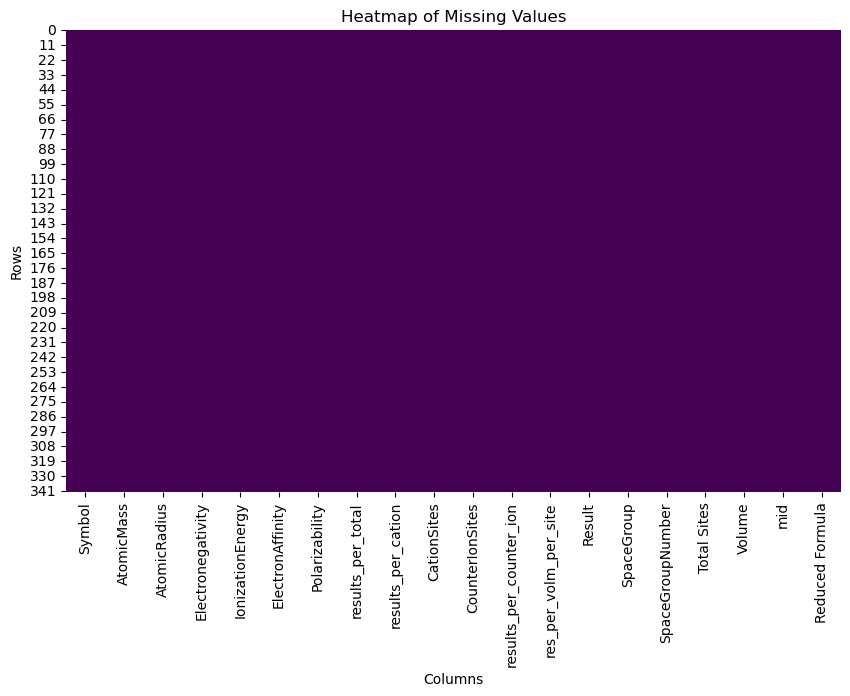

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(all_props_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [15]:
# all_props_df.to_csv('all_props_new.csv', index=False)
all_props_df = pd.read_csv('all_props.csv')

all_props_df

,Symbol,AtomicMass,AtomicRadius,Electronegativity,IonizationEnergy,ElectronAffinity,Polarizability,results_per_total,results_per_zn,ZnSites,CounterIonSites,results_per_counter_ion
0,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.012687,0.038062,1.0,1.0,0.038062
1,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.008223,0.008855,26.0,26.0,0.008855
2,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.011320,0.016980,4.0,4.0,0.016980
3,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.009284,0.011140,10.0,10.0,0.011140
4,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.010972,0.029258,6.0,6.0,0.029258
...,...,...,...,...,...,...,...,...,...,...,...,...
159,Se,78.97,190.0,2.55,9.752,2.021,28.90,0.002714,0.005429,1.0,1.0,0.005429
160,S,32.07,180.0,2.58,10.360,2.077,19.40,0.002662,0.005324,28.0,28.0,0.005324
161,Te,127.60,206.0,2.10,9.010,1.971,38.00,0.002715,0.005429,3.0,3.0,0.005429
162,Zn,65.40,139.0,1.65,9.394,NaN,38.67,0.015521,0.023282,4.0,4.0,0.023282
